# Iris Recognition Project 

### Tonghong Chen | April 4th, 2018

<img src="iricore.jpg" width=50% height=50%  align="left"/>

<img src="output.png" width=100% height=100%  align="left"/>

<font color='INDIANRED' size=4>

IMPORTANT NOTE: <br><br>
to save running time, I've saved the results up to iris normalization to the same zip files (train_normalized, test_normalized). 
<br>
<br>
I suggest to skip all the code before image enhancement and execute the "pickle.load(fp)" to quickly get the normalization results


# Data Preparation

In [1]:
import os
import glob 
import cv2
import pandas as pd

** First, I load all the train and test images, flatten each of them to an array, and save the arrays into a dataframe, as it will make the following jobs easier. **

In [2]:
train_db = []
test_db = []
train_location = []
test_location = []

# this path function works for windows. On Mac it may need some modifications
database_dir = os.path.join(os.getcwd(), 'CASIA Iris Image Database (version 1.0)')
for i in range(1,109,1):
    person_index = '{:03}'.format(i)
    person_imgs = os.path.join(database_dir, person_index)
    train_dir = os.path.join(person_imgs, "1")
    test_dir = os.path.join(person_imgs, "2")

    train_list = glob.glob(os.path.join(train_dir, "*.bmp"))
    test_list =  glob.glob(os.path.join(test_dir, "*.bmp"))
    
    train_location += train_list
    test_location += test_list

    for img_train in train_list:
        img_flat = cv2.imread(img_train, 0).ravel()  
        train_db.append(img_flat)
        
    for img_test in test_list:
        img_flat = cv2.imread(img_test, 0).ravel()  
        test_db.append(img_flat)

** As mentioned above, save the flatten images into a dataframe ** 

In [3]:
train = pd.DataFrame(train_db, columns=[i for i in range(280*320)]) # the image dimension is 280*320
test = pd.DataFrame(test_db, columns=[i for i in range(280*320)]) # the image dimension is 280*320

** Then, I write a helper function to save the images' paths to two files, so that MatLab could access the images quickly while doing iris localization. **

In [4]:
f = open("train_location.txt","w+")
for row in train_location:
    f.write(row+"\n") 
f.close()

f = open("test_location.txt","w+")
for row in test_location:
    f.write(row+"\n") 
f.close()

****

# Image Preporcessing

In [5]:
import numpy as np
import os
from scipy.io import loadmat

### I. Iris Localization

**This section contains four functions: ** 

binarize_by_pupil(img), 

find_pupil_center(img_vector), 

IrisLocalization.m  

get_pupil_and_iris_circle(mode, dataset)

** binarize_by_pupil：** use a historgram method to estimate the area of pupil. by investing the historgram, I use the value of 4000th data point as the threshold for binarizing pupil 

** find_pupil_center： ** find the estimated center coordinate from the binarlized image 

** IrisLocalization.m： ** 

this is a MatLab script, as I found that the localization accuracy of MatLab is much better than Python openCV or skimage. 

This script use "train_location.txt" and "test_location.txt" to quickly access the images paths and perform localization, I set a high radius range and high sensitive, so that each image will have a lot of circles detected. 

After detecting the cricles for a cetrain image, the script will save all the circles into either "MatLab_circle_train" or "MatLab_circle_test" folders, dependng on if it's working on a train or test image

**get_pupil_and_iris_circle:** this script will access the localization results (circles) by IrisLocalization.m. Then based on the distance to the estimated pupil center, it will find the optimal pupil circle and iris circle, whose centers are closest to the estimated pupil center。

In [6]:
## use a historgram method to estimate the area of pupil
def binarize_by_pupil(img):
    threshold = sorted(img)[4000]
    def binarize(img):
        new_img = 0 if img <= threshold else 255
        return new_img
    binarize = np.vectorize(binarize)
    return binarize(img)

In [7]:
## use the 'pure-black' data ponts' locations after binarization to estimate the center
def find_pupil_center(img_vector):
    counter = 0
    row_total = 0.0
    col_total = 0.0
    for i in range(len(img_vector)):
        if img_vector[i] == 0:    # if the point lies in our estimated pupil zone
            row_i = int(i/320)    # then get the point's coordinate
            col_i = i % 320
            
            row_total += row_i
            col_total += col_i
            counter+=1

    row_index = int(row_total/counter)  # calculate the average row index
    col_index = int(col_total/counter)  # calculate the average coloum index
    return (row_index, col_index)

In [8]:
## find the optimal pupil and iris circle
def get_pupil_and_iris_circle(mode=None, dataset=None):
    MatLab_Circle_Train = os.path.join(os.getcwd(), 'MatLab_Circle_'+mode)
    counter = 0
    pupils = []
    iriss = []
    
    # get all the estimated circles acqured by Matlab
    for i in range(1, dataset.shape[0]+1, 1):    
        fname = os.path.join(MatLab_Circle_Train, mode+'_circle_'+str(i)+'.mat')
        result = loadmat(fname)['c'][0]
        
        pupil_centers = result[0]
        pupil_radiis = result[1]
        
        if len(result) == 5:
            iris_centers = result[2]
            iris_radiis = result[3]  
            img_name = result[4]
        else:  # Bad image quality. Have to estimate the iris circle based on pupil center
            print("the "+str(i)+" image does not find iris. Need to estimate its value!")
            iris_centers = []
            iris_radiis = []
            for j in range(len(pupil_centers)):
                iris_radiis.append([2*pupil_radiis[j][0]])
                iris_centers.append([pupil_centers[j][0], pupil_centers[j][1]])                             
        
        
        #### get the corresponding image data
        img = dataset.loc[i-1].values

        #### get the best iris center and radius
        #### We use the min distance to estimated pupil center to approximately estimate the best iris circle
        pupil_estimated_center = find_pupil_center(binarize_by_pupil(img.ravel()))    
        
        best_iris_x = None
        best_iris_y = None
        best_iris_radius = None
        min_dist = 1000
        for j in range(len(iris_centers)):
            iris_x = iris_centers[j][1]
            iris_y = iris_centers[j][0]
            iris_radius = iris_radiis[j][0]  
            dist = np.sqrt((iris_x-pupil_estimated_center[0]) ** 2 + (iris_y -pupil_estimated_center[1]) ** 2)
            if dist < min_dist:
                min_dist = dist
                best_iris_x = iris_x
                best_iris_y = iris_y
                best_iris_radius = iris_radius
                
            
        #### get the best pupil center and radius, based on the min distance to the estimated center
        # intialize the data
        best_pupil_x = None
        best_pupil_y = None
        best_pupil_radius = None
        min_dist = 300  # threadshold. if the distance is larger than this, then there is probably a problem
        
        # search for the best pupil circle
        search_counter = 0
        while best_pupil_x is None:
            if search_counter > 0:  # if we do a bad segmentation and can't find pupil inside the iris
                best_iris_radius+=5 # manually enlarge the iris circle       
            for j in range(len(pupil_centers)):
                pupil_x = pupil_centers[j][1]
                pupil_y = pupil_centers[j][0]
                pupil_radius = pupil_radiis[j][0]

                if ((pupil_x+pupil_radius <= best_iris_x+best_iris_radius) and (pupil_x-pupil_radius >= best_iris_x-best_iris_radius) 
                    and (pupil_y+pupil_radius <= best_iris_y+best_iris_radius) and (pupil_y-pupil_radius >= best_iris_y-best_iris_radius)):
                    dist = np.sqrt((pupil_x-pupil_estimated_center[0]) ** 2 + (pupil_y -pupil_estimated_center[1]) ** 2)
                    if dist < min_dist:
                        min_dist = dist
                        best_pupil_x = pupil_x
                        best_pupil_y = pupil_y
                        best_pupil_radius = pupil_radius
            search_counter+=1

        ## append the results
        if best_iris_x is not None and best_iris_y is not None and best_iris_radius is not None:
            iris = [best_iris_x, best_iris_y, best_iris_radius]
            iriss.append(iris)
        else:
            print(fname)
            raise ValueError('iris has one requried value missing. Check it!!')       
            
        if best_pupil_x is not None and best_pupil_y is not None and best_pupil_radius is not None:
                pupil = [best_pupil_x, best_pupil_y, best_pupil_radius]
                pupils.append(pupil)       
        else:       
            print(fname)
            raise ValueError('pupil has one requried value missing. Check it!!')
            
    
    return (pupils, iriss)

**Find the best estimated pupil and iris circles from all the circles localized by MatLab**

**CAUTION: the below operation could run up to 5 minutes. I suggest skip this line as we will load the results from disk directly **

In [9]:
# train_pupils, train_iriss = get_pupil_and_iris_circle(mode='train',dataset=train)
# test_pupils, test_iriss = get_pupil_and_iris_circle(mode='test',dataset=test)

the 303 image does not find iris. Need to estimate its value!


**Below are some localization results for visualization**

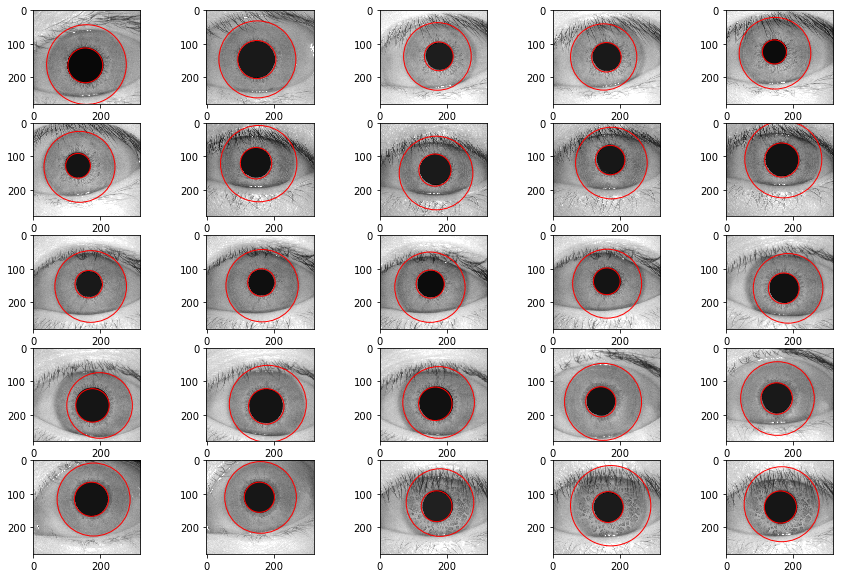

In [10]:
from matplotlib import pyplot as plt
mode = 'test'   # parameter1: this should be 'train' or 'test'
start = 50      # parameter2: should be less than len(total image) - 25
end = start+25

if mode == 'train':
    content = train
elif mode == 'test':
    content = test

f, axarr = plt.subplots(5,5, figsize=(15,10))
counter = 0
for i in range(start, end,1):
    row = counter//5
    col = counter%5
    counter+=1   
    
    if mode == 'train':
        data1 = train_pupils[i]
        data2 = train_iriss[i]
    else:
        data1 = test_pupils[i]
        data2 = test_iriss[i]
        
    pupil_row = data1[0]
    pupil_col = data1[1]
    pupil_radis = data1[2]
    
    iris_row = data2[0]
    iris_col = data2[1]
    iris_radis = data2[2]
    
    img = content.values[i,:].reshape(280,320)
    axarr[row, col].imshow(img,cmap = 'gray')
    axarr[row, col].add_artist(plt.Circle((pupil_col, pupil_row), pupil_radis, color='r', fill=False))
    axarr[row, col].add_artist(plt.Circle((iris_col, iris_row), iris_radis, color='r', fill=False))
    
plt.show()

### II. Iris Normalization

** The normalization algorithm is the same denoted in the paper **

In [11]:
import pickle
import numpy as np

In [12]:
def iris_normalization(data=None, pupils=None, iriss=None):
    def normalization(img, pupil, iris):   
        M = 64
        N = 512
        band = np.zeros((M, N))  
        pupil_row = pupil[0]
        pupil_col = pupil[1]
        pupil_radius = pupil[2]
        iris_row = iris[0]
        iris_col = iris[1]
        iris_radius = iris[2]

        for Y in range(M):
            for X in range(N):

                # calculate theta
                theta = 2*np.pi*X/N

                # get the inner boundary coordinate
                yp = pupil_row + pupil_radius*np.sin(theta)
                xp = pupil_col + pupil_radius*np.cos(theta)

                # get the outer boundary coordinate
                yi = iris_row + iris_radius*np.sin(theta)
                xi = iris_col + iris_radius*np.cos(theta)

                x = min(int(xp + (xi-xp)*Y/M),319)
                y = min(int(yp + (yi-yp)*Y/M),279)      

                band[Y][X] = img[y][x]
        return band
    
    bands = []
    #for i in range(0,len(pupils),1):
    for i in range(0,len(pupils),1):
        img = data.loc[i].values.reshape(280, 320)        
        pupil = pupils[i]
        iris = iriss[i]

        band = normalization(img, pupil, iris)           
        bands.append(band)
        
        if (i+1) % 50 == 0 or i == (len(pupils)-1):
            print("{0} images have been transformed".format(i+1))
                        
    return bands   

In [13]:
def run_normalization_and_save(train_pupils, train_iriss, test_pupils, test_iriss):
    train_normalized = iris_normalization(data=train, pupils=train_pupils, iriss=train_iriss)
    with open('train_normalized', 'wb') as fp:
        pickle.dump(train_normalized, fp)

    test_normalized = iris_normalization(data=test, pupils=test_pupils, iriss=test_iriss)
    with open('test_normalized', 'wb') as fp:
        pickle.dump(test_normalized, fp)   
    
    return train_normalized, test_normalized

**CAUTION: the below operation could run up to 10 minutes. I suggest skip this line, as we will load the results from disk just after this line. **

In [22]:
# train_normalized, test_normalized = run_normalization_and_save(train_pupils, train_iriss, test_pupils, test_iriss)

****

****

### Load the normalized results from disk (this should be the real start point)

In [1]:
import pickle
with open('train_normalized', 'rb') as fp:
    train_normalized = pickle.load(fp)
    
with open('test_normalized', 'rb') as fp:
    test_normalized = pickle.load(fp)

** Below are some examples of the localization results**

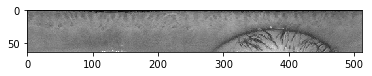

In [2]:
from matplotlib import pyplot as plt
plt.imshow(train_normalized[0],cmap='gray');
plt.show()

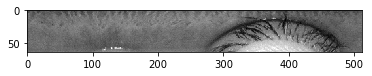

In [3]:
from matplotlib import pyplot as plt
plt.imshow(test_normalized[0],cmap='gray');
plt.show()

### III. Iris Enhancement

** Although I've implemented the illumination adjustment denoted in the paper, skipping the illumination adjustment to perform the histrogram equalization directly works better in my case. **

In [4]:
from skimage.measure import block_reduce
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [5]:
def iris_enhancement(img, illumination=False):  
    if illumination is True: # apply illumination adjustment
        #@the illumination estimation does not work well, so although I have coded them, I decided not to use them   
        # calculate the 4x32 mean_pool_transformed matrix
        mean_pool = block_reduce(img, (16,16),np.mean)

        # estimate the illumination by bicubic interpolation
        estimated_illumination = cv2.resize(mean_pool, (512, 64), interpolation =cv2.INTER_CUBIC)

        # subtract the estimated illumination from the original image. If we get negative value then set to 0
        enhanced_image = img - estimated_illumination
        enhanced_image = enhanced_image - np.amin(enhanced_image.ravel())  # rescale back to (0-255)
    
    elif illumination is False: # does not apply illumination adjustment
        enhanced_image = img - 0
        
    # perform the histogram equalization in each 32x32 region
    for row_index in range(0, enhanced_image.shape[0], 32):
        for col_index in range(0, enhanced_image.shape[1],32):
            sub_matrix = enhanced_image[row_index:row_index+32, col_index:col_index+32]
            # apply histogram equalization in each 32x32 sub block
            enhanced_image[row_index:row_index+32, col_index:col_index+32] = cv2.equalizeHist(sub_matrix.astype("uint8"))  
            
    return enhanced_image

** Implement the iris enhancement **

In [6]:
enhanced_list_train = []
enhanced_list_test = []

for img in train_normalized:
    enhanced_list_train.append(iris_enhancement(img, illumination=False))

for img in test_normalized:
    enhanced_list_test.append(iris_enhancement(img, illumination=False))

** Below is an example of the 1st image before and after image enhancement**

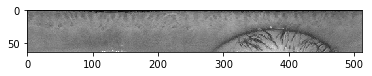

In [7]:
from matplotlib import pyplot as plt
plt.imshow(train_normalized[0],cmap='gray');
plt.show()

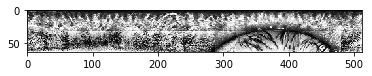

In [8]:
from matplotlib import pyplot as plt
plt.imshow(enhanced_list_train[0], cmap='gray');
plt.show()

****

# Feature Extraction

In [9]:
from scipy import signal
import numpy as np

** Below is the defined gabor filter function denoted in the paper. **

**In the following implementation, I set the kernel size to 3, which yields the best results comparing with other sizes **

In [10]:
def defined_filter(size, sigma_x, sigma_y):

    f = 1.0/sigma_y   
    filter_mat = np.zeros((size,size))
    
    for xi in range(size):
        for yi in range(size):
            x = xi-size//2
            y = yi-size//2
            gaussian_value = 1/(2*np.pi*sigma_x*sigma_y) * np.exp(-1.0/2 * (x**2/sigma_x**2 + y**2/sigma_y**2))
            M1 = np.cos(2*np.pi*f*np.sqrt(x**2+y**2))
            filter_mat[yi][xi] = gaussian_value * M1

    return filter_mat   

** Below is the algorithm of feature extraction in the paper **

In [11]:
def execute_feature_extraction(input):
    
    ## function to extract the feature of 8x8 blocks
    def feature_extraction(filtered_img_1, filtered_img_2):
        V = []
        for row_index in range(0, filtered_img_1.shape[0], 8):  # use stride = 8
                for col_index in range(0, filtered_img_1.shape[1],8):  # use stride = 8
                    # process the first filtered image
                    sub_region_vec1 = abs(filtered_img_1[row_index:row_index+8, col_index:col_index+8].ravel())
                    # calculate m and sigma as denoeted in the paper
                    m1 = sub_region_vec1.mean()
                    sigma1 = 1/64 * (abs(sub_region_vec1-m1).sum())
                    V.append(m1)
                    V.append(sigma1)

                    # process the second filter image
                    sub_region_vec2 = abs(filtered_img_2[row_index:row_index+8, col_index:col_index+8].ravel())
                    # calculate m and sigma as denoeted in the paper
                    m2 = sub_region_vec2.mean() 
                    sigma2 = 1/64 * (abs(sub_region_vec2-m2).sum())
                    V.append(m2)
                    V.append(sigma2)
        return V  
    
    output = []
    filter1 = defined_filter(size=3, sigma_x=3, sigma_y=1.5)    # 3x3 defined gabor filter
    filter2 = defined_filter(size=3, sigma_x=4.5, sigma_y=1.5)  # 3x3 defined gabor filter
    
    # process the input data
    for img_enhanced in input:
        # get region of interest
        img = img_enhanced[:48,:]  
        
        # convolve the image by the two filters
        filtered_img_1 = signal.convolve2d(img, filter1, mode='same', boundary='wrap')
        filtered_img_2 =  signal.convolve2d(img, filter2, mode='same', boundary='wrap')
        
        # get the 1536x1 feature vector
        V = feature_extraction(filtered_img_1, filtered_img_2)
        
        #append the output
        output.append(V)
    
    return output

** Implement the feature extraction **

In [12]:
feature_extracted_train = execute_feature_extraction(enhanced_list_train)
feature_extracted_test = execute_feature_extraction(enhanced_list_test)

****

# Iris Matching

In [13]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors.nearest_centroid import NearestCentroid
from skimage.measure import block_reduce
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

** Below is the function of nearest centroid classifier with D1, D2 and D3 distances. The function will take train and test data, perform LDA transformation if needed, and calculate the L1, L2, COS distance between each pair of train and test data. The it will predict each test data's label (three for each test data) based on the minimum distance's index of the three distance metrics.**

In [14]:
def nearest_centroid_classifier(train_X, test_X, lda = None):   
    
    ## get the L1, L2, COS distance between f and fis
    def get_distance_matrix(f, fis):
        values_mat = np.zeros((fis.shape[0],3))

        for i in range(fis.shape[0]):
            fi = fis[i].reshape(fis.shape[1],1)
            d1 = abs(f-fi).sum()                     
            d2 = np.asscalar( (f-fi).T.dot(f-fi) )
            d3 = 1 - np.asscalar(f.T.dot(fi)) / (np.linalg.norm(f)*np.linalg.norm(fi))
            values_mat[i,:] = np.array([d1,d2,d3])   
        return values_mat
    
    test_target = test_X
    fis = block_reduce(train_X, (3,1), np.mean)  # use mean to calculate the fi
    
    ## if we want to apply LDA for dimension reduction
    if lda is not None:
        test_target = lda.transform(test_target) 
        fis = lda.transform(fis)
 
    ## get the prediction and value list
    prediction_list = []
    values_list = []
    #distance_list = []
    
    ## loop to get each f in the test target
    for i in range(test_target.shape[0]):
        
        ## calculate the three distances between f and fi, then predict f's class by the min dist index
        f = test_target[i,:].reshape(test_target.shape[1],1)
        dist_mat = get_distance_matrix(f,fis)   # the distances matrix of f and fis
        min_index = np.argmin(dist_mat,axis=0)  # the min idnex of the distances marix
        prediction = min_index + 1              # the predictions of f
        
        ## get the value of prediction
        values = []
        value_matrix = dist_mat[min_index]
        values.append(value_matrix[0][0])
        values.append(value_matrix[1][1])
        values.append(value_matrix[2][2])
        
        ## append the results to the output lists
        prediction_list.append(prediction)
        values_list.append(values)
        #distance_list.append(values_mat)
    
    return (values_list, prediction_list)

** Below is the function to evaluate the classification accuracy rate with the three distances. Both prediction_list and Y are nx3 matrix (n: number of test data; 3: the three distance metrics), where prediction_list contains the prediction by the nearest centroid classifier, and Y contains the true label of test data**

In [15]:
def evaluate(prediction_list, Y):
    ## create a 1x3 list to save the total number of the 
    # correct classification of the three distances
    true_classificaton = np.zeros(3)  
    for i in range(len(Y)):
        prediction = prediction_list[i]
        if prediction[0] == Y[i]:
            true_classificaton[0]+=1
        if prediction[1] == Y[i]:
            true_classificaton[1]+=1
        if prediction[2] == Y[i]:
            true_classificaton[2]+=1
    return true_classificaton/Y.shape[0]

** After defining the function, I start train the model and predcit the test data's classes**

### Prepare the train and test data

In [16]:
train_X = np.array(feature_extracted_train)
train_Y = np.array([(i//3+1) for i in range(train_X.shape[0])])
test_X = np.array(feature_extracted_test)
test_Y = np.array([(i//4+1) for i in range(test_X.shape[0])])

### Prediction Method 0: Original Feature Vector, as denoted in the paper

In [17]:
values_Org, predictions_Org = nearest_centroid_classifier(train_X, test_X, lda=None)

### Prediction Method I: Simple LDA, as denoted in the paper

In [18]:
lda_org = LDA().fit(train_X, train_Y)   # the following section will tell us this LDA is the best
values_LDA, predictions_LDA = nearest_centroid_classifier(train_X, test_X, lda=lda_org)

### Prediction Method II: Standardization+ PCA + LDA

** Since the LDA projections are computed via eigen-decomposition of ΣW−1 * ΣB, where ΣW and ΣB are within- and between-class covariance matrices. If the number of obsercations are less than N data points (where N is the dimensionality of the space, in our case it is 1536; the number of obsercations in our case is 324), then ΣW will be singular and therefore cannot be inverted. In this case, there is no way to perform LDA directly. **

** To resolve this problem, it's better for us to perform a first-round feature dimension with PCA, then perform a second-round feature dimension by fitting a LDA model with the transformed data. More details can be found in this paper: **

** https://www.ijert.org/download/4043/improved-face-recognition-by-combining-lda-and-pca-techniques **

In [41]:
def PCA_LDA_model(train_X, train_Y, test_X, test_Y):
    
    ##### First, standardize train and test data to gain better result
    train_X_std = StandardScaler().fit_transform(train_X)
    test_X_std = StandardScaler().fit_transform(test_X)
    
    ##### Second,tune the best n component for PCA
    n_arr = [i for i in range(10, 324, 10)]  # number of componenets to tune
    recognition_rates = np.empty(len(n_arr)) # compare list of the recognition_rate with i components
    
    for i in range(len(n_arr)):
        ## use the tuned PCA model to perform the first-time feature dimension
        pca = PCA(n_components=n_arr[i]).fit(train_X_std)
        train_X_tf_std = pca.transform(train_X_std)
        test_X_tf_std = pca.transform(test_X_std)

        ## use the reduced train dataset to fit a lda model for the second-time feature dimention
        lda=LDA().fit(train_X_tf_std, train_Y)

        ## get the prediction_list and save it into the compare list
        prediction_list = nearest_centroid_classifier(train_X_tf_std, test_X_tf_std, lda)[1]
        max_recognition_rate = np.amax(evaluate(prediction_list, test_Y))
        recognition_rates[i] = max_recognition_rate
    
    ##### Third, perform the optimal PCA transformation on data and refit the LDA model
    best_components = n_arr[np.argmax(recognition_rates)]
    print("the optimal number of component is: ", best_components)
    pca = PCA(n_components=best_components).fit(train_X_std)
    train_X_tf_std = pca.transform(train_X_std)
    test_X_tf_std = pca.transform(test_X_std)

    ##### Finally, retrain the nearest centroid classifier with the refitted LDA model
    lda=LDA().fit(train_X_tf_std, train_Y)
    
    #### get the output
    values_PCA, predictions_PCA = nearest_centroid_classifier(train_X_tf_std, test_X_tf_std, lda)
    
    return values_PCA, predictions_PCA

In [23]:
values_PCA, predictions_PCA = PCA_LDA_model(train_X, train_Y, test_X, test_Y)

** In the next section, we can see that this method yields the best accuracy with consine distance **

****

# Evaluation

<font color='INDIANRED' size = 4>
To be consistent with the paper, I performs most of the following evaluations only on the simple LDA model.
</font>

<b><font color='purple' size = 5>
Part I: Iris Identification Evaluation
</font></b>

### RRC Table

In [24]:
from prettytable import PrettyTable
def plot_CRR(originals, transforms1, transforms2):
    ## convert the input data to 100% scale
    originals = originals*100
    transforms1 = transforms1*100
    transforms2 = transforms2*100
    
    ## construct the table
    table = PrettyTable()
    table.field_names = ["Similarity Measurement", "Original feature Set", "Reduced feature set (only LDA)", "Reduced feature set (PCA+LDA)"]
    table.add_row(["L1 distance measure",originals[0],transforms1[0], transforms2[0]])
    table.add_row(["L2 distance measure", originals[1], transforms1[1], transforms2[1]])
    table.add_row(["Cosine similarity measure", originals[2], transforms1[2], transforms2[2]])
    print("TABLE of Correct Recognition Rate (%) Using Different Similarity Measures")
    print(table)

** Below is the implementation of the above function to draw the desired CRR table**

In [25]:
originals = evaluate(predictions_Org, test_Y)
transforms1 = evaluate(predictions_LDA, test_Y)
transforms2 = evaluate(predictions_PCA, test_Y)
plot_CRR(originals, transforms1, transforms2)

TABLE of Correct Recognition Rate (%) Using Different Similarity Measures
+---------------------------+----------------------+--------------------------------+-------------------------------+
|   Similarity Measurement  | Original feature Set | Reduced feature set (only LDA) | Reduced feature set (PCA+LDA) |
+---------------------------+----------------------+--------------------------------+-------------------------------+
|    L1 distance measure    |    80.0925925926     |         85.1851851852          |         84.4907407407         |
|    L2 distance measure    |    72.4537037037     |         86.3425925926          |         84.7222222222         |
| Cosine similarity measure |    73.1481481481     |         87.7314814815          |         91.8981481481         |
+---------------------------+----------------------+--------------------------------+-------------------------------+


### RRC using features of different dimensionality

In [26]:
from matplotlib import pyplot as plt
def plot_LDA_tunning(tunning_values, rates):
    fg = plt.figure(figsize=(5, 5))
    ax = fg.add_subplot(111)

    ax.set_xlabel("Dimensionality of the feature vector", size="large")
    ax.set_ylabel("Correct regonition rate", size="large")

    line_cv = ax.plot(tunning_values, rates, label="recognition rate", marker='o')

    ax.legend(loc="best", fontsize="large")
    plt.show()

** Below is the implementation of the above function to draw the RRC curve with different dimensions**

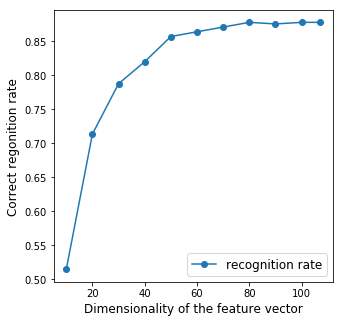

In [27]:
n_arr = [i for i in range(10, 108, 10)]+[107]
recognition_rates = np.empty(len(n_arr))
for i in range(len(n_arr)):
    lda = LDA(n_components=n_arr[i])
    lda.fit(train_X, train_Y) 
    max_recognition_rate = np.amax(evaluate(nearest_centroid_classifier(train_X, test_X, lda=lda)[1], test_Y))
    recognition_rates[i] = max_recognition_rate

plot_LDA_tunning(n_arr, recognition_rates)

<b><font color='purple' size = 5>
Part II: Iris Verification Evaluation
</font></b>

### FM and FNM Table (cos distance, Point + CI estimators)

In [28]:
from random import randint

** Below is a function to calculate the false_match_rate, false_non_match_rate, true_positive_rate, and false_positive_rate, given a threadshold, a list of prediction, and a list of corresponding cosine distance**

In [29]:
def metrics_calculator(cos_dist, cos_prediction, threashold, boostrap=False):  
    TP = 0; FP = 0; TN = 0; FN = 0
    false_match_rate = None
    false_non_match_rate = None   
    true_positive_rate = None
    false_positive_rate = None
    total = len(cos_dist)
    divider = 4 if boostrap==False else 1
    
    ## calculate the TP, FP, TN, FN values 
    for i in range(total):                
        if cos_dist[i] < threashold:   #match
            if cos_prediction[i] == (i//divider)+1:  #correct prediction
                TP += 1
            else:  #wrong prediction
                FP += 1

        else:   #non match
            if cos_prediction[i] == (i//divider)+1:  #correct prediction           
                FN += 1
            else:  #wrong prediction
                TN += 1
    
    ## calculate the false_match_rate, false_non_match_rate, true_positive_rate, false_positive_rate
    if TP > 0 or FP > 0:
        false_match_rate = FP/(TP+FP)
    if TN > 0 or FN > 0:
        false_non_match_rate = FN/(TN+FN)   
    if TP > 0 or FN > 0:
        true_positive_rate = TP/(TP+FN)
    if FP > 0 or TN > 0:
        false_positive_rate = FP/(FP+TN)
    
    return (false_match_rate, false_non_match_rate, true_positive_rate, false_positive_rate)

** Below is a function for boostrap, where we darw 108 test samples with replacement 5000 times **

In [30]:
def boostrap(cos_dist, cos_prediction, threashold):
    boostrap_fms = []
    boostrap_fnms = []
    boostrap_tprs = []
    boostrap_fprs = []
    
    for k in range(5000):  ## Boostrap 5000 times
        selected_case = np.array([randint(0,3) for i in range(108)])
        intervals = np.array([i for i in range(0, 432, 4)])
        selected_index = selected_case+intervals
        
        new_cos_dist = cos_dist[selected_index]
        new_cos_prediction = cos_prediction[selected_index]
        
        false_match_rate, false_non_match_rate, true_positive_rate, false_positive_rate = metrics_calculator(
            new_cos_dist, new_cos_prediction, threashold, boostrap=True)
        
        boostrap_fms.append(false_match_rate)
        boostrap_fnms.append(false_non_match_rate)
        boostrap_tprs.append(true_positive_rate)
        boostrap_fprs.append(false_positive_rate)
        
    return (boostrap_fms, boostrap_fnms, boostrap_tprs, boostrap_fprs)

** Below is a function to calculate the confidencec interval by the boostrap result and a significance level**

In [31]:
def confidence_interval_boostrap(boostrap_result, alpha=0.05):
    asc_list = sorted(boostrap_result)
    lower_bound_index = int(len(asc_list)*alpha/2)
    upper_bound_index = int(len(asc_list)*(1-alpha/2))
    lb = asc_list[lower_bound_index]
    up = asc_list[upper_bound_index]
    return (lb, up)

** Below is the implementation of the above functions to draw the desired FMR-FNMR table**

In [32]:
cos_dist = np.asarray(values_LDA)[:,2]
cos_prediction = np.asarray(predictions_LDA)[:,2]

## get the point estimates
fm1, fnm1, tpr1, fpr1 = metrics_calculator(cos_dist, cos_prediction, 0.446)
fm2, fnm2, tpr2, fpr2 = metrics_calculator(cos_dist, cos_prediction, 0.472)
fm3, fnm3, tpr3, fpr3 = metrics_calculator(cos_dist, cos_prediction, 0.502)

## get the interval estimates
(boostrap_fms, boostrap_fnms, _, _) = boostrap(cos_dist, cos_prediction, 0.446)
boostrap_fms_446_lb, boostrap_fms_446_up = confidence_interval_boostrap(boostrap_fms)
boostrap_fnms_446_lb, boostrap_fnms_446_up = confidence_interval_boostrap(boostrap_fnms)

(boostrap_fms, boostrap_fnms, _, _) = boostrap(cos_dist, cos_prediction, 0.472)
boostrap_fms_472_lb, boostrap_fms_472_up = confidence_interval_boostrap(boostrap_fms)
boostrap_fnms_472_lb, boostrap_fnms_472_up = confidence_interval_boostrap(boostrap_fnms)

(boostrap_fms, boostrap_fnms, _, _) = boostrap(cos_dist, cos_prediction, 0.502)
boostrap_fms_502_lb, boostrap_fms_502_up = confidence_interval_boostrap(boostrap_fms)
boostrap_fnms_502_lb, boostrap_fnms_502_up = confidence_interval_boostrap(boostrap_fnms)

In [33]:
table = PrettyTable()
table.field_names = ["Threshold", "False match rate (%)", "False non-match rate (%)"]
table.add_row([0.446, "{0:.3f} [{1:.3f},{2:.3f}]".format(fm1, boostrap_fms_446_lb,boostrap_fms_446_up), 
               "{0:.3f} [{1:.3f},{2:.3f}]".format(fnm1, boostrap_fnms_446_lb,boostrap_fnms_446_up)])

table.add_row([0.472, "{0:.3f} [{1:.3f},{2:.3f}]".format(fm2, boostrap_fms_472_lb,boostrap_fms_472_up), 
               "{0:.3f} [{1:.3f},{2:.3f}]".format(fnm2, boostrap_fnms_472_lb,boostrap_fnms_472_up)])

table.add_row([0.502,"{0:.3f} [{1:.3f},{2:.3f}]".format(fm3, boostrap_fms_502_lb,boostrap_fms_502_up), 
               "{0:.3f} [{1:.3f},{2:.3f}]".format(fnm3, boostrap_fnms_502_lb,boostrap_fnms_502_up)])
print("False Match and False Nonmatch Rates with Different Threshold Values")
print(table)

False Match and False Nonmatch Rates with Different Threshold Values
+-----------+----------------------+--------------------------+
| Threshold | False match rate (%) | False non-match rate (%) |
+-----------+----------------------+--------------------------+
|   0.446   | 0.000 [0.000,0.000]  |   0.743 [0.644,0.837]    |
|   0.472   | 0.000 [0.000,0.000]  |   0.710 [0.600,0.812]    |
|   0.502   | 0.004 [0.000,0.016]  |   0.679 [0.564,0.789]    |
+-----------+----------------------+--------------------------+


### Curve Evaluation (cosine distance)

In [34]:
from sklearn import metrics

In [35]:
def plot_curve(fprs, tprs, label, xlabel, ylabel, title, color='b'):
    plt.plot(fprs,tprs, label=label, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=20)
    plt.legend(loc='best')
    plt.show()

** try different threadsholds, and save the corresponding false_match_rate, false_non_match_rate, true_positive_rate, false_positive_rate**

In [36]:
threadshold_arr = [i for i in np.arange(0.12, 0.78, 0.02)]
fms = []; fnms = []; tprs = []; fprs = []
for threadshold_i in threadshold_arr:
    fm, fnm, tpr, fpr = metrics_calculator(cos_dist, cos_prediction, threadshold_i)
    fms.append(fm)
    fnms.append(fnm)
    tprs.append(tpr)
    fprs.append(fpr)

#### ROC Curve

** plot the ROC curve with the false_positive_rate and true_positive_rate under different threadsholds**

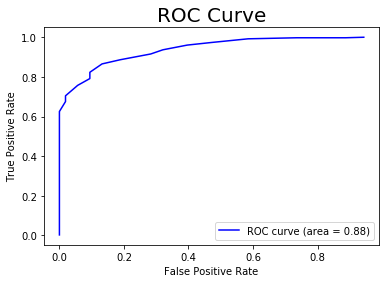

In [37]:
plot_curve(fprs, tprs, 
         'ROC curve (area = %0.2f)' % metrics.auc(fprs, tprs, reorder=False), 
         "False Positive Rate", "True Positive Rate", "ROC Curve")

#### FMR and FNMR Curve

** plot the FMR-FNMR curve with the false_match_rate and false_non_match_rate under different threadsholds**

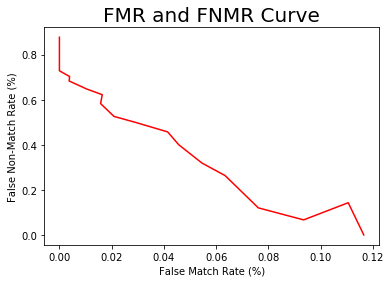

In [38]:
plot_curve(fms, fnms,  None, 
           "False Match Rate (%)", "False Non-Match Rate (%)", "FMR and FNMR Curve",'r')